In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import random as ra
import math

In [2]:
input_size = 784
hidden_size0 = 32
hidden_size1 = 16     
out_size = 1
epochs = 10            
batch_size = 64
learning_rate = 0.001

In [3]:
test_dataset = datasets.MNIST(root='./data',
                           train=False,
                           transform=transforms.ToTensor())

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

In [4]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size0, hidden_size1, out_size):
        super(Net, self).__init__()
        self.fc0 = nn.Linear(input_size, hidden_size0)     #784 - 32
        self.fc1 = nn.Linear(hidden_size0, hidden_size1)   #32 - 16
        self.fc2 = nn.Linear(hidden_size1, out_size)       #16 - 10
        self.tanh = nn.Tanh()
        self.init_weights()

    def init_weights(self):
        nn.init.xavier_uniform_(self.fc0.weight, gain=nn.init.calculate_gain('tanh')) 
        nn.init.xavier_uniform_(self.fc1.weight, gain=nn.init.calculate_gain('tanh'))
        nn.init.xavier_uniform_(self.fc2.weight, gain=nn.init.calculate_gain('tanh'))

    def forward(self, x):
        out = self.tanh(self.fc0(x))
        out = self.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [5]:
net = Net(input_size, hidden_size0, hidden_size1, out_size)
CUDA = torch.cuda.is_available()
if CUDA:
    net = net.cuda()

In [6]:
dig_to_check = 8
net.load_state_dict(torch.load(f"stored_model_weights_binary/ffn_mnist_binary_{dig_to_check}.pth"))

<All keys matched successfully>

In [7]:
def compute_final_contributions(net, activations_fc0):
    w1 = net.fc1.weight.detach().cpu()
    w2 = net.fc2.weight.detach().cpu()

    contribs = torch.zeros(activations_fc0.shape[0])

    for i in range(activations_fc0.shape[0]):
        a0 = activations_fc0[i].item()
        total = 0
        for j in range(w1.shape[0]):
            w0 = w1[j, i].item()
            a1 = torch.tanh(torch.tensor(a0 * w0))
            w1_2 = w2[0, j].item()
            total += a1.item() * w1_2
        contribs[i] = total

    return contribs



Prediction: tensor([True], device='cuda:0')


/tmp/ipykernel_52517/3515768020.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


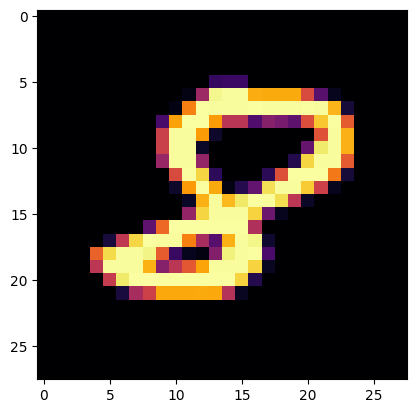

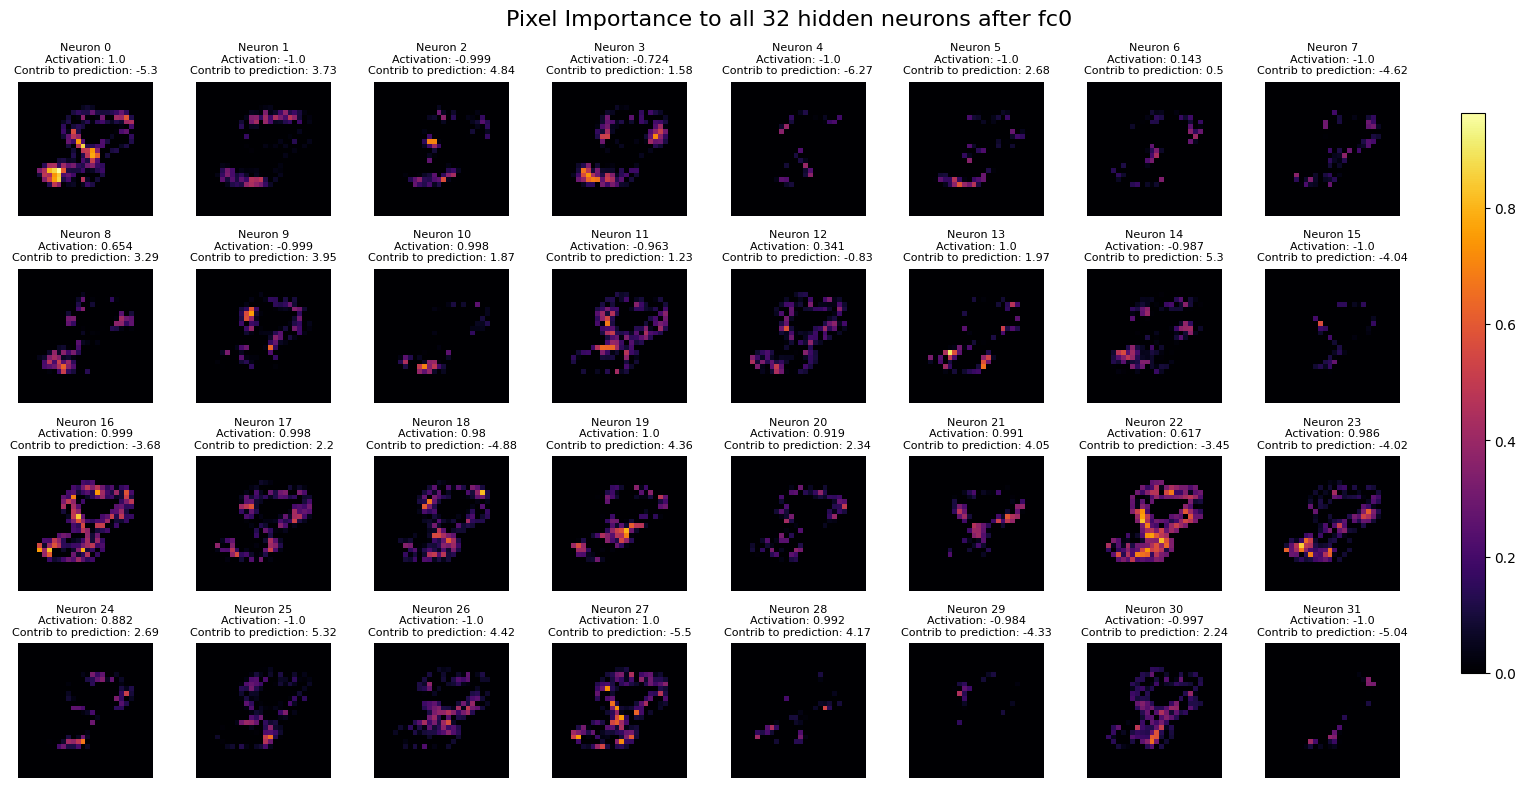

In [11]:

inputs, labels = next(iter(test_loader))

#search wanted digit:
while True:
    ind = ra.randrange(0, len(inputs))
    if labels[ind] == dig_to_check:
        img = inputs[ind].squeeze()
        break

#img = torch.full((28, 28), 255).float()

output = net(img.view(-1).cuda())
print(f"Prediction: {torch.softmax(output, dim=0) >= 0.5}")
plt.imshow(img, cmap="inferno")

img_flat = img.view(-1)
weights = net.fc0.weight.detach().cpu()
biases = net.fc0.bias.detach().cpu()
contribs = weights * img_flat #[32, 784]

#normalise to [0, 1]
contribs_imgs = (contribs / contribs.max()).view(-1, 28, 28)

mask = torch.where(
    contribs_imgs == 0,
    torch.tensor(0.0, device=contribs_imgs.device),
    torch.tensor(1.0, device=contribs_imgs.device)
)

contribs_imgs += biases[:, None, None]
contribs_imgs *= mask #remove bias where background = 0 for visualisation 

activations = torch.tanh(net.fc0(img.view(1, -1).cuda())).squeeze()
final_contribution = [round(con.item(), 2) for con in compute_final_contributions(net, activations)]

fig, axes = plt.subplots(4, 8, figsize=(16, 8))
vmax = contribs_imgs.max().item()

for i, ax in enumerate(axes.flat):
    im = ax.imshow(contribs_imgs[i], cmap='inferno', vmin=0, vmax=vmax)
    ax.set_title(f'Neuron {i}\nActivation: {round(activations[i].item(), 3)}\nContrib to prediction: {final_contribution[i]}', fontsize=8)
    ax.axis('off')

fig.suptitle('Pixel Importance to all 32 hidden neurons after fc0', fontsize=16)
cbar_ax = fig.add_axes([0.92, 0.15, 0.015, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()



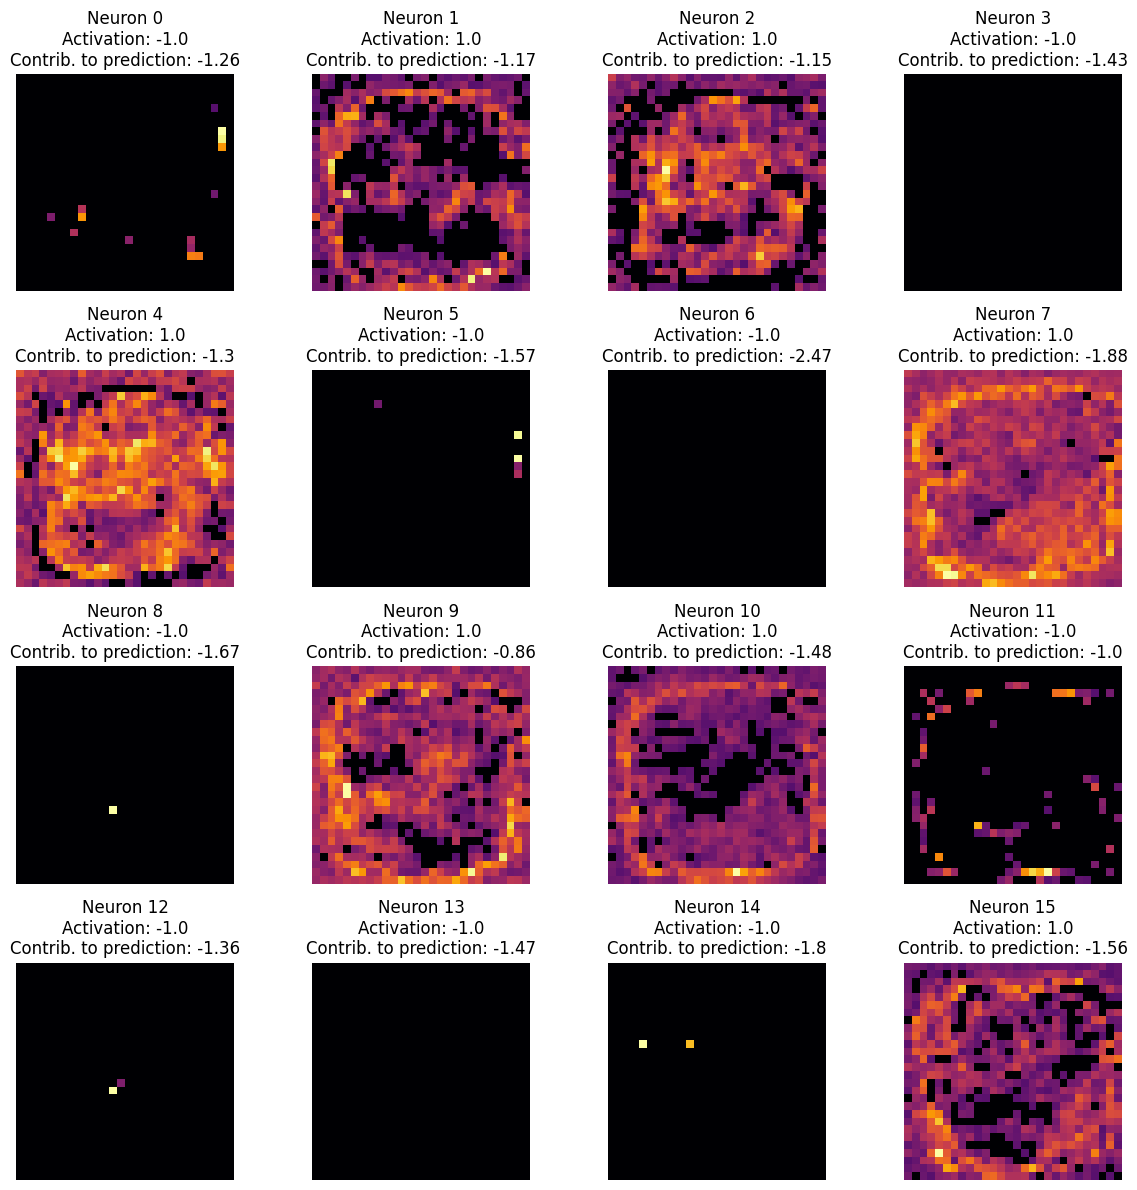

In [9]:
weights_fc1 = net.fc1.weight.detach().cpu().unsqueeze(-1).unsqueeze(-1)
biases_fc1 = net.fc1.bias.detach().cpu()

combined = (weights_fc1 * contribs_imgs.unsqueeze(0)).sum(dim=1)
max_val = combined.max()
combined = combined / max_val

mask = torch.where(
    combined == 0,
    torch.tensor(0.0, device=combined.device),
    torch.tensor(1.0, device=combined.device)
)

combined += biases_fc1[:, None, None]
combined *= mask

combined_copy = combined.clone()

per_img_max = combined.view(len(combined), -1).max(dim=1)[0]
thresholds = (0.25 * per_img_max).view(len(combined), 1, 1)

combined = torch.where(
    combined == 0,
    torch.tensor(0.0, device=combined.device),
    torch.where(
        combined > thresholds,
        combined,
        torch.tensor(0.0, device=combined.device)
    )
)

weights_fc2 = net.fc2.weight.detach().cpu()
activations = [torch.tanh(mat.sum()).squeeze() for mat in combined_copy]

contribs_out_class = [round(activations[idx].item() * weights_fc2[0, idx].item(), 2) for idx in range(16)]

fig, axes = plt.subplots(4, 4, figsize=(12, 12))
for idx, ax in enumerate(axes.flat):
    ax.imshow(combined[idx].cpu(), cmap='inferno')
    ax.axis('off')
    ax.set_title(f'Neuron {idx}\nActivation: {round(activations[idx].item(), 2)}\nContrib. to prediction: {contribs_out_class[idx]}')

plt.tight_layout()
plt.show()


In [10]:
#scattered neuron attention makes neuron recognising human concepts very unlikely, since human concepts are normally localised and continuously connected pixels.
#therefore the neurons wouldn't have such a scattered attention, inevitably taking into account all the different pixels, but they do, because they don't learn concepts.
#They overfit on pixel arrangements and style, which I will further elaborate on in 05_model_limitations.ipynb and in the paper.